今さら聞けないGANシリーズを参考にGANの実装をやってみる  
https://qiita.com/triwave33/items/1890ccc71fab6cbca87e  
  
  
はじめてのGAN も参照する．  
https://elix-tech.github.io/ja/2017/02/06/gan.html#code  
GANは学習が難しいが，基本となる学習テクニックが書いてあるのでいざという時には参照するといい．

余談: もう一つ面白い結果を紹介します。Word2Vecという単語ベクトルで「王様」-「男」+「女」=「女王」という演算ができることは有名ですが、GANにおける入力であるzベクトルを使っても同様の演算を行うことができます。下の例では、「サングラスをかけた男」-「男」+「女」=「サングラスをかけた女」という演算を行っています。

Word2Vecと音楽自動生成で何かできない？

# 今さら聞けないGAN(1)

## 基本構造
基本構造  
z → Generator → img(生成データ) → Discriminator → Validation  

z: 潜在変数，通常 $[0, 1]^{100}$のようなベクトル  
一様分布や正規分布からランダムサンプリングされる．  
つまり，zが画像生成のための種であると言える．  

Discriminatorは本物である場合1, 偽物である場合0を出力する．  
その確率が返ってくる．  

データは，実態ではなくデータを流し込むための窓口と考える．  
TensorflowでいうPlaceholder

## Discriminator(識別器)の学習

Discriminatorはr-img: 本物の画像 と g-img: 偽物の画像を識別する．  
正解ラベルとして，本物(1)か偽物(0)の値を使用する．  

(g-img, label=0), (r-img, label=1)  

g-imgのデータは実際にGeneratorにデータを作らせる．  
また，Discriminatorの学習とGeneratorの学習は無関係である．

## Generatorの学習
z → Generator → img → Discriminator（重み固定非学習) → Valid ↔️ label  

Discriminatorの重みを学習によって変化させない．  
これにより，Generator~Discriminatorの部分をCombinedネットワークとし，このネットワークの学習を行ってGeneratorのみを学習させる．  

ここで，noiseからGeneratorによって生成された画像は偽物であるが，これに本物のラベル(1)を使って学習させる．  
Generatorの目的はDiscriminatorを騙すことなので，識別結果が本物と判定される方がGeneratorにとっては嬉しく，自分を変える必要がない(loss関数が小さい)という結果になるからである．  

DiscriminatorもGeneratorも，binary crossentropyをloss関数に用いる．

## 基本構造のKerasコード
https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
を基本写経  
この後拡張していくので，gan.pyに書いた．

### LeakyReLUについて．  
https://qiita.com/miyamotok0105/items/3435930cc04650bce54d  
今日ではReLUを使用するべき．(隠れ層では)  
ニューロンの出力が0ばかりになってしまうようならLeakyReLUを使うといい．  
勾配爆発を防ぐ．

### BatchNormalizationについて  
https://deepage.net/deep_learning/2016/10/26/batch_normalization.html  訓練データのサンプリングと予測データの入力の分布に偏りがあってアルゴリズムが対応できなくなることを共変量シフトと呼ぶ．  
DeepNetworkの各層，各活性化層ごとに入力分布が変わってしまうことを内部共変量シフトと呼ぶ．  
平均を0にして，標準偏差を1に，そして特徴成分を非相関にすることを白色化と呼ぶ．白色化をした方がNNの収束が速くなることが知られている．  
データの前処理だけではなく，DeepNetworkの各層で白色化を行うというのが，BatchNormalizationの基本的なアイデア．  

#### BatchNormalizationのアルゴリズム  
入力: $m$ 個のデータからなるmini-batch $\beta = \{ x_1, ..., x_m \}$  
出力: $m$ 個のデータからなる変換されたmini-batch $\beta ' = \{ y_1, ..., y_m \}$  

$\beta$から平均$\mu_\beta$と分散$\sigma^2_\beta$を求める．  

mini-batchの各要素$x_i$を次のように変換する．  
$$\hat{x_i} = \frac{x_i - \mu_\beta}{\sqrt{\sigma^2_\beta+ \epsilon} }$$
$$y_i = A \hat{x_i} + B $$
ここで，$A, B$は学習対象となるパラメータである？

これにより，学習速度が速くなる．  
過学習気味になるときは，Dropoutを追加したりする．  
Dropoutは一部のニューロンをランダムに取り除いて学習することでモデルを単純化し，過学習を抑制するテクニックだった気がする．

## loss関数
$$ min_G max_D V(D, G) = \mathbb{E}_{x 〜 p_{data}(x)}[\log{D(x)}] + \mathbb{E}_{z 〜 p_z(z)}[\log{(1 - D(G(z)))}] $$

### Discriminatorについて
Generatorを固定した上で上式を最大化  
  
第1項は本物データ($x$)を用いるケース  
第1項を最大化するには，logの中身を1に近づける．  
つまり，$D(x)$が1になるときを多くする．  
$\mathbb{E}$は全ての実データについて識別を行なった結果の平均．  
第1項の最大値は1になる．  
  
第2項はGeneratorによって生成されたデータを識別することを意味する．  
log内部を最大化するには，$D$の出力を0に近づける．  
つまり，$D(z)$が0になるときを多くする．
  
### Generatorについて
Discriminatorは固定でGeneratorのみに依存するので，第2項のみを考える．  
第2項を最小化するには，logの中身を0に近づける．  
つまり，$D(x)$が1, 生成データを本物と間違えるようにする．

## 層の数とニューロン数の学習への影響について
http://www.natural-science.or.jp/article/20170428135749.php  
このサイト曰く  
- 中間層の数は2〜4程度
- 各層のニューロン数は100~1000程度  

が良いとされている  

https://www.youtube.com/watch?v=OwccN7rj4Qg  
の動画では  
- 認識問題では最初の層を大きく，最後の層を小さくしていく
- 生成問題では最初の層を小さく，最後の層を大きくしていく  
- 試行錯誤でN数を変える場合は，全体の数を二倍したり，半分にしたりして，割合を維持
    - だから2^nのニューロン数がよく使われているみたい

In [1]:
import tensorflow.compat.v1 as tf
from keras.backend import tensorflow_backend
from tensorflow.python.util import deprecation

deprecation._PRINT_DEPRECATION_WARNINGS = False
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True), 
    log_device_placement=True
)
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16240781088502467581
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10686230244716492954
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9894348258186003547
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2998567182931975955
physical_device_desc: "device: XLA_GPU device"
]


In [8]:
from gan import GAN
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

Visualize: Discriminator


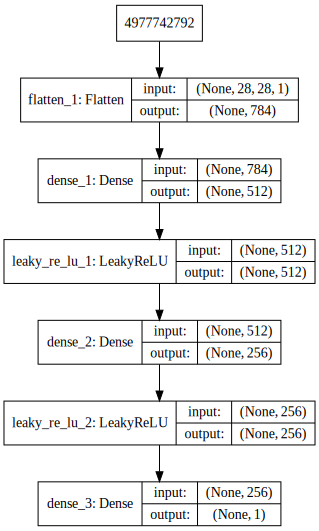

In [2]:
gan.visualize_discriminator()

Visualize: Generator


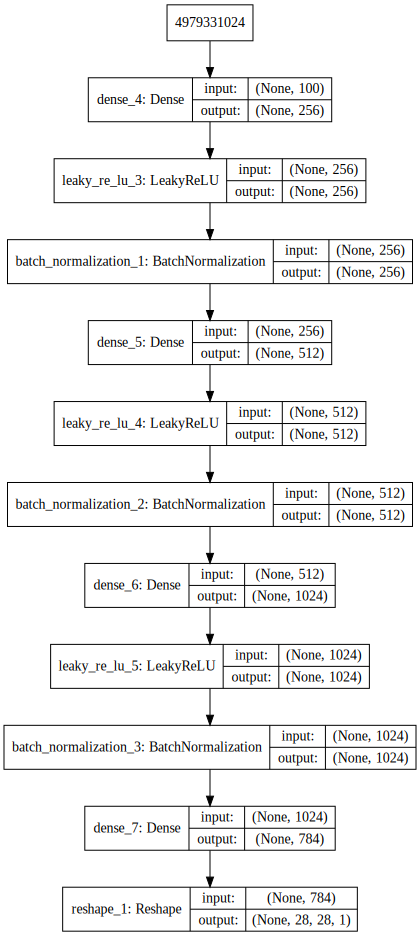

In [3]:
gan.visualize_generator()

Visualize: Combined


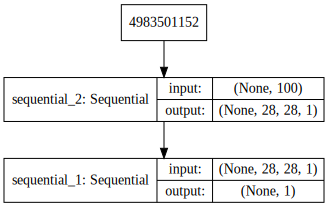

In [4]:
gan.visualize_combined()

In [9]:
gan.train(epochs=30000, batch_size=32, save_interval=3000)

0 [D loss: 0.723953, acc.: 56.25%] [G loss: 0.859098]


/root/gan/.venv/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3000 [D loss: 0.725019, acc.: 53.12%] [G loss: 0.826536]


KeyboardInterrupt: 

optimizerの値をちょっと変えただけで全然うまくいかなかった．  
optimizerのパラメータをqiitaのものにしたらしっかりめに数字が浮かび上がってきた．

# 改良
より良い生成モデルを作るには，損失関数を変えていく．  
- サンドノイズを除去したい
    - 単純な多層NNを使っているため
    - 通常NNは隣接ノード(ピクセル)間の関係について考慮しない
    - CNNを用いたDCGANを使うことで改善
- 生成させる文字，数字を指定したい
    - 学習時に文字の正解ラベルを取り込む必要がある．
    - conditional-GANによって改善